# TP2

### Roussel Desmond Nzoyem - M2 CSMI

In [17]:
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint

from gekko import GEKKO

In [18]:
plt.style.use("seaborn")

Le but de ce T.P. est de déterminer une stratégie optimale de mise en place de mesures de restrictions sur une population afin de lutter contre la propagation d’une épidémie. Le modèle utilisé est le suivant (nommé __SIR__ en référence aux proportions Saines, Infectées, et Retirées):

\begin{align*}
S'(t) &= -u(t) \frac{S(t)I(t)}{N(t)} \\
I'(t) &= u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) \\
R'(t) &= \beta I(t) \\
(S(0),I(0),R(0)) &= (S_0, R_0, I_0)
\end{align*}

où $N(t)$ représente la population globale au temps $t$, $u(t) \in [0,\alpha]$ la loi de commande, $\alpha$ et $\beta$ respectivement les taux d’infection et d'élimination de la maladie. 

La recherche d’une stratégie de restriction optimale se fait par la minimisation d'une fonctionnnelle $L_{\tau}$ sur $\mathcal{U}_{ad} = \{ u \in L^{\infty}(]0,T[) \,\, t.q. \, 0 \leq u(\cdot) \leq \alpha \}$.



## Question 1

### Justification du choix de la fonctionnelle $L_{\tau}$

La fonctionnnelle $L_{\tau}$ à minimiser s'écrit:
$$
L_{\tau}(u) = \tau \int_0^T g(u(t))\,dt + (1-\tau) \int_0^T f(I(t))\,dt
$$
où
$$
g(u) = \frac{1}{2}(\alpha^2 - u^2), \qquad f(I)=\frac{I^2}{2}
$$

- Le terme en __$g$__ indique le besoin de __limiter le confinement__ (en faisant en sorte que la loi de commande $u$ se rapproche le plus de $\alpha$). Ce besoin de limiter le confinement peut être justifié par le fait qu'un confinement est coûteux (versement de prestations, aides exceptionnelles, recrutement de psychologues, etc.).
- Le terme en __$f$__ indique le besoin naturel de __limiter la propagation du virus__, en minimisant le nombre d'infectés (en faisant en sorte que la quantité $f(I)$, et donc le nombre d'infectés $I$ se rapproche le plus de 0). Tout comme le terme en $g$, ce terme en $f$ est un terme intégral, indiquant le besoin de contrôler cette quantité durant toutes la duré de l'expérience. 

## Question 2

### Vérifions que La fonction $N(\cdot)$ est constante

Vu que $N(t)=S(t)+I(t)+R(t)$, on a 

\begin{align*}
\frac{dN(t)}{dt} &= \frac{dS(t)}{dt} + \frac{dI(t)}{dt} + \frac{dR(t)}{dt} \\
&= -u(t) \frac{S(t)I(t)}{N(t)} + u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) + \beta I(t) \\
&= 0
\end{align*}

La population globale $N(\cdot)$ est donc constante. Ceci enlève un degré de liberté au problème, nous permettant de facilement interpréter les résultats qui vont suivre. Cette constance sera aussi utile lors du calcul du gradient de la fonctionnel $L_{\tau}$.

## Question 3

### Résolution du système SIR par une méthode de Runge-Kutta d'ordre 4

Dans le cas de contrôles constants ($u(\cdot)=\alpha$ ou $u(\cdot)=\varepsilon$, avec $\varepsilon > 0$), utilisons la méthode de Runge-Kutta d’ordre 4 pour résoudre le système SIR sur $[0,T]$. 

In [19]:
## Variables globales définies pour tout le notebook
S0, I0, R0 = 6.7e7-2e4, 2e4, 0
N = 6.7e7
T = 90
alpha = 0.32
beta = 0.1

In [20]:
def F(t, X, u):
    f1 = -u*X[0]*X[1]/N
    f2 = u*X[0]*X[1]/N - beta*X[1]
    f3 = beta*X[1]
    return np.array([f1, f2, f3])

def RungeKutta4(u, stepCount):
    t = np.linspace(0,T,stepCount)
    h = t[1:] - t[:-1]          ## h_n = t_np1 - t_n
    
    X = np.array([S0, I0, R0])
    Xvals = [list(X)]

    for n in range(stepCount-1):
        un = u[n]                                   ## u à cette étape

        k1 = F(t[n], X, un)
        k2 = F(t[n]+h[n]/2.0, X+h[n]*k1/2.0, un)    ## Euler explicite entre t_n et t_np1sur2
        k3 = F(t[n]+h[n]/2.0, X+h[n]*k2/2.0, un)    ## Euler implicite entre t_n et t_np1sur2
        k4 = F(t[n]+h[n], X+h[n]*k3, un)

        X += h[n] * (k1+2*k2+2*k3+k4) / 6.0
        Xvals.append(list(X))

    return np.vstack(Xvals)

In [21]:
## Une fonctino pour afficher l'état du système
def plotSIR(t, Xvals, ax, title, show=[0,1,2]):

    if 0 in show or show is None:
        ax.plot(t, Xvals[:,0], label="S", c='g')
    if 1 in show or show is None:
        ax.plot(t, Xvals[:,1], label="I", c='r')
    if 2 in show or show is None:
        ax.plot(t, Xvals[:,2], label="R", c='b')

    ax.set_xlabel("Temps")
    ax.set_ylabel("Population")
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()

### 1er cas: $u(\cdot)=\alpha$

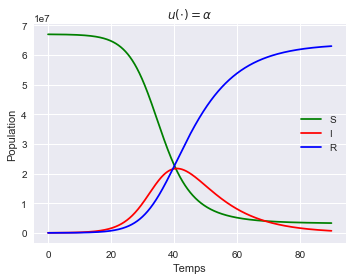

In [22]:
stepCount = 1000 # discretisation en temps
t = np.linspace(0,T,stepCount)

u = alpha*np.ones(stepCount)
Xvals = RungeKutta4(u, stepCount)

fig, ax = plt.subplots(1,1,figsize=(5,4))
plotSIR(t, Xvals, ax, "$u(\cdot) = \\alpha$")

Vu que $u(\cdot)=\alpha$ représente le taux de transmission de la maladie au cours du temps, on constate que la population saine se retrouve très vite infectée. La pandémie atteint son pic après $40$ jours après
quoi le nombre d'infectés se met subitement à décroitre, dû au "manque" de personnes saines à contaminer. À la fin des 90 jours de simulation, on remarque que presque toute la population a été contaminée et retirée de l'expérience. 

Remarquons que le comportement décrit ci-haut est attendu car durant toute l'expérience, le taux de reproduction du virus, défini à tout temps $t$ par $\mathcal{R}_0(t) = \frac{u(t)}{\beta} = \frac{\alpha}{\beta} = 3.2$ est supérieur à $1$. Ceci traduit une transmission non freinée du virus, d'où l'infection totale de la population après seulement 40 jours.

### 2eme cas: $u(\cdot)=\varepsilon$

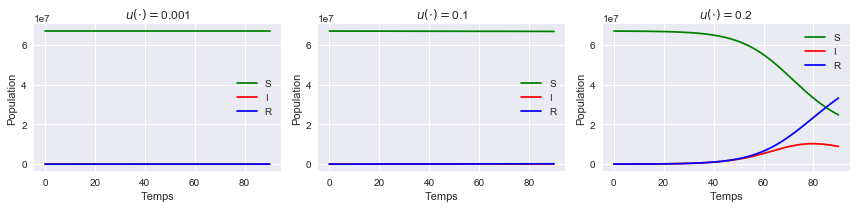

In [23]:
## Affichage de R et I uniquement
stepCount = 1000 # discretisation en temps
t = np.linspace(0,T,stepCount)

fig, ax = plt.subplots(1,3,figsize=(12,3))

epsilon = [1e-3, beta, 0.2]
for i in range(3):
    u = epsilon[i]*np.ones(stepCount)
    Xvals = RungeKutta4(u, stepCount)
    plotSIR(t, Xvals, ax[i], "$u(\cdot) =$"+str(epsilon[i]), show=[0,1,2])

Pour les trois cas ci-haut, affichons uniquement $I$ et $R$ afin d'interpréter plus facilement les résultats.

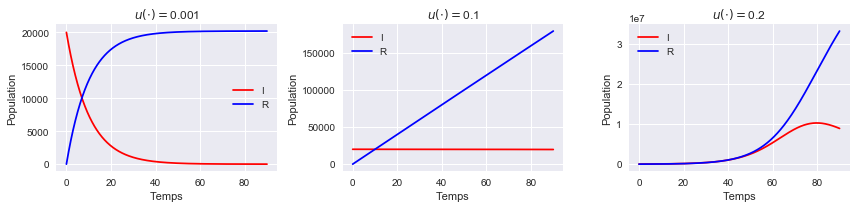

In [24]:
## Affichage de R et I uniquement pour un affichage à l'échelle
fig, ax = plt.subplots(1,3,figsize=(12,3))

# ax[0].set_yscale("log")
# ax[1].set_yscale("log")
# ax[2].set_yscale("log")

for i in range(3):
    u = epsilon[i]*np.ones(stepCount)
    Xvals = RungeKutta4(u, stepCount)
    plotSIR(t, Xvals, ax[i], "$u(\cdot) =$"+str(epsilon[i]), show=[1,2])

Tant que $u(\cdot)=\varepsilon$ (taux de transmission de la maladie) est inférieur à $\beta$ (taux de disparition), l'épidémie aura tendance à disparaitre sans occasionner plus de victimes ($\varepsilon=0.001 \text{  ou  } \varepsilon=0.1$). On remarque le phénomène inverse pour $u(\cdot)> \beta$. Observons ces cas en détails :
- Pour $\varepsilon=0.001 < \beta$, les infectés initiaux sont convertis en retirés et le système n'évolue plus (disparition du virus après 40 jours). En effet, la propagation de la maladie cesse lorsque les malades initiaux ont étés retirés de l'expérience (décédés, soignés, mis en quarantaine, etc).
- Pour $\varepsilon=0.1 = \beta$, le nombre d'infectés évolue très faiblement (de 20000 à 19707) dû à la non-propagation du virus et aux conditions initiales. La vitesse de conversion des sains en infectés est égale à la vitesse de conversion des infectés en retirés, ce qui justifie cette faible évolution du nombre d'infectés. Cette stratégie de restriction retarde effectivement l'évolution de l'épidémie, mais n'est pas optimale (d'un point de vue économique ou sanitaire) étant donné le nombre d'infectés au début de l'expérience qui est relativement élevé ($I_0 = 2e4$). En effet cela nécessiterait pour une durée indéterminée, des ressources pour assurer le confinement, sans jamais éradiquer le virus. 
- Pour $\varepsilon=0.2 > \beta$, on remarque naturellement une augmentation du nombre d'infectés. Le virus atteint toute la population après $80$ jours. Bien que ce cas conduise lui aussi à une infection globale de la population, il est important de remarquer qu'il est moins sévère que le cas $u(\cdot)=\alpha = 3.2$ vu que la courbe des infectés est ici considérablement étalée, donnant ainsi le temps aux autorités (et aux personnels soignants) de mieux se préparer pour le pic.  


## Question 4

### Calcul du gradient de $L_{\tau}$

Soit $v\in L^{\infty}(]0,T[)$ tel que $h = v-u \in \mathcal{U}_{ad}$. On a bien, pour tout $\varepsilon \in [0,1]$, $u+\varepsilon h \in \mathcal{U}_{ad}$ par convexité de $\mathcal{U}_{ad}$.

On écrit 
\begin{align}
DL_{\tau}(u)\cdot h &= \lim_{\varepsilon \rightarrow 0} \frac{L_{\tau}(u+\varepsilon h) - L_{\tau}(u)}{\varepsilon} \\
&= \frac{d}{d\varepsilon} L_{\tau}(u+\varepsilon h)  \bigg\rvert_{\varepsilon=0} \\
&= \tau \int_0^T \frac{d}{d\varepsilon} g(u+\varepsilon h)\,dt + (1-\tau)\int_0^T \frac{d}{d\varepsilon} f(I_{u+\varepsilon h})\,dt  \bigg\rvert_{\varepsilon=0} \\
&= \tau \int_0^T g'(u(t)) \,h(t)\,dt + (1-\tau)\int_0^T f'(I(t)) \, \dot{I'}(t))\,dt \\
&= -\tau \int_0^T u(t)\,h(t)\,dt + (1-\tau)\int_0^T I(t) \, \dot{I'}(t))\,dt
\end{align}
où les dérivées directionnelles de l'état SIR au point $u$ sont données par
$$
\dot{S}(t) = \lim_{\varepsilon \rightarrow 0} \frac{S_{u+\varepsilon h}(t) - S_u(t)}{\varepsilon}, \qquad \dot{I}(t) = \lim_{\varepsilon \rightarrow 0} \frac{I_{u+\varepsilon h}(t) - I_u(t)}{\varepsilon}, \qquad \dot{R}(t) = \lim_{\varepsilon \rightarrow 0} \frac{R_{u+\varepsilon h}(t) - R_u(t)}{\varepsilon}
$$
où écrit différemment,
$$
\dot{S}(t) = \frac{d}{d\varepsilon} S_{u+\varepsilon h}(t) \bigg\rvert_{\varepsilon=0} \qquad \dot{I}(t) = \frac{d}{d\varepsilon} I_{u+\varepsilon h}(t) \bigg\rvert_{\varepsilon=0} \qquad \dot{R}(t) = \frac{d}{d\varepsilon} R_{u+\varepsilon h}(t) \bigg\rvert_{\varepsilon=0}
$$


Dérivons à présent une expression en fonction de $h(t)$ pour le terme $I(t) \, \dot{I'}(t)$, présent dans l'expression de $DL_{\tau}(u)\cdot h$.

$N$ étant constant, on a 
\begin{align*}
S'_{u+\varepsilon h}(t) &= -(u(t)+\varepsilon h(t)) \frac{S_{u+\varepsilon h}(t)\,I_{u+\varepsilon h}(t)}{N}
\end{align*}
d'où
\begin{align*}
\dot{S'}(t) &= \frac{d}{d\varepsilon} S'_{u+\varepsilon h}(t) \bigg\rvert_{\varepsilon=0} \\
&= -h(t)\frac{S_{u+\varepsilon h} I_{u+\varepsilon h}}{N} - (u(t)+\varepsilon h(t))\frac{d S_{u+\varepsilon h}(t)}{d\varepsilon} I_{u+\varepsilon h}(t) - (u(t)+\varepsilon h(t)) S_{u +\varepsilon h} \frac{d I_{u+\varepsilon h}}{d\varepsilon} \bigg\rvert_{\varepsilon=0} \\
&= -h(t) \frac{S(t)\,I(t)}{N} - u(t) \frac{\dot{S}(t)\,I(t)}{N} - u(t) \frac{S(t)\,\dot{I}(t)}{N}
\end{align*}

De façon similaire, on obtient 

\begin{align*}
\dot{I'}(t) = h(t) \frac{S(t)\,I(t)}{N} + u(t) \frac{\dot{S}(t)\,I(t)}{N} + u(t) \frac{S(t)\,\dot{I}(t)}{N} - \beta \dot{I}(t) \qquad \text{et} \quad
\dot{R'}(t) = \beta \dot{I}(t)
\end{align*}

De plus, 
\begin{align*}
\dot{S}(0) &= \lim_{\varepsilon \rightarrow 0} \frac{S_{u+\varepsilon h}(0) - S_u(0)}{\varepsilon} \\
&= \lim_{\varepsilon \rightarrow 0} \frac{S_0 - S_0}{\varepsilon} \\
&= 0
\end{align*}

De même, $$\dot{I}(0) = \dot{R}(0) = 0$$

À présent, introduisons l'état adjoint $(P_1, P_2, P_3)^T$ à travers une multiplication par les dérivées (en $t$ et en $u$) des états correspondants (les dépendances en $t$ ne seront plus indiquées dorénavant):

\begin{align}
\int_0^T \dot{S}'\, P_1 \, dt + \int_0^T \dot{I}'\, P_2 \, dt + \int_0^T \dot{R}'\, P_3 \, dt = \int_0^T \left( -h \frac{SI}{N} P_1 - u \frac{\dot{S}I}{N} P_1 - u \frac{\dot{I}S}{N} P_1 \right) \, dt  + \int_0^T \left( h \frac{SI}{N} P_2 + u \frac{\dot{S}I}{N} P_2 + u \frac{\dot{I}S}{N} P_2 -\beta \dot{I}P_2 \right) \, dt + \int_0^T \left(\beta \dot{I}P_3 \right) \, dt
\end{align}

- Une intégration par parties du membre du gauche donne l'expression :
\begin{align}
    - \int_0^T \dot{S}\, P_1' + \dot{I}\, P_2'  +  \dot{R}\, P_3' \, dt + \left[ P_1 \dot{S} + P_2\dot{I} + P_3\dot{R} \right]_{t=0}^{t=T} = - \int_0^T \dot{S}\, P_1' + \dot{I}\, P_2'  +  \dot{R}\, P_3' \, dt 
\end{align}
car 
\begin{align}
    P_1(T) = P_2(T) = P_3(T) = 0 \quad \textbf{et} \quad \dot{S}(0) = \dot{I}(0) = \dot{R}(0) = 0
\end{align}

- Un regroupement des termes sur le membre de droite donne l'expression :

\begin{align}
    \int_0^T h \left( \frac{SI}{N}P_2 -\frac{SI}{N}P_1 \right) + A \, (\dot{S}, \dot{I}, \dot{R})^T \cdot (P_1, P_2, P_3)^T \, dt
\end{align}
où la matrice $A$ est convenablement définie dans l'énoncé de cette question. 

On a donc montré que 

$$
- \int_0^T (\dot{S}, \dot{I}, \dot{R})^T \cdot (P_1', P_2', P_3')^T \, dt = \int_0^T h \left( \frac{SI}{N}P_2 -\frac{SI}{N}P_1 \right) + (\dot{S}, \dot{I}, \dot{R})^T \cdot A^T \, (P_1, P_2, P_3)^T \, dt
$$

En remplacant le vecteur $(P_1', P_2', P_3')^T$ par son expression donnée dans l'énoncé, on obtient au final 
$$
- \int_0^T \dot{I}\, I \, dt = \int_O^T  h \frac{SI}{N} \left(P_2 -P_1 \right)
$$

On remplace cette valeur dans l'expression de $DL_{\tau} \cdot h$ obtenue au tout début. On obtient alors (les dépendances en $t$ ne sont pas indiquées)
\begin{align}
DL_{\tau}(u) \cdot h  &= -\tau \int_0^T u\,h\,dt + (1-\tau)\int_0^T h \frac{SI}{N} \left(P_2 -P_1 \right) \,dt \\
&= \left\langle -\tau u + (1-\tau) \frac{SI}{N} \left(P_2 -P_1 \right),\, h \right\rangle_{L^2(0,T)}
\end{align}

On a donc calculé le gradient de $L_{\tau}$, qui vaut
$$
\nabla L_{\tau}(u) = -\tau u + (1-\tau) \frac{SI}{N} \left(P_2 -P_1 \right)
$$


## Question 5

### Mise en œuvre d’une méthode de gradient pour résoudre le problème. 

Nous commencerons par rédiger un code de calcul pour le problème adjoint, ensuite nous passerons à la méthode de descente de gradient proprement dite.

### Résolution du problème adjoint

In [25]:
P1_final, P2_final, P3_final = 0.0, 0.0, 0.0 ## Etat adjoint au temps final

In [26]:
def FAdjoint(t, P, X, u):
    A1 = [-u*X[1]/N, -u*X[0]/N, 0]
    A2 = [u*X[1]/N, (u*X[0]/N)-beta, 0]
    A3 = [0, beta, 0]
    A = np.array([A1, A2, A3])
    return -A.T@P - np.array([0, X[1], 0])

def RungeKutta4Adjoint(u, Xvals, stepCount):
    t = np.linspace(T,0,stepCount)      ## Sens retrograde
    h = t[1:] - t[:-1]

    h = np.ones((stepCount))*(-T/stepCount)
    P = np.array([P1_final, P2_final, P3_final])
    Pvals = [list(P)]

    for n in range(stepCount-1):
        X = Xvals[stepCount-n-1]                    ## S, I, et R de l'etape
        un = (u[stepCount-n-1]+u[stepCount-n-2])/2  ## Une moyenne des u
        # un = u[stepCount-n-1]

        k1 = FAdjoint(t[n], P, X, un)
        k2 = FAdjoint(t[n]+h[n]/2.0, P+h[n]*k1/2.0, X, un)
        k3 = FAdjoint(t[n]+h[n]/2.0, P+h[n]*k2/2.0, X, un)
        k4 = FAdjoint(t[n]+h[n], P+h[n]*k3, X, un)

        P += h[n] * (k1 + 2*k2 + 2*k3 + k4) / 6.0
        Pvals.append(list(P))
        # print(P)

    return np.flip(np.vstack(Pvals), axis=0)

In [27]:
def plotAdjoint(t, Pvals, ax, title, show=[0,1,2]):

    if 0 in show or show is None:
        ax.plot(t, Pvals[:,0], label=r"$P_1$", c='g')
    if 1 in show or show is None:
        ax.plot(t, Pvals[:,1], label=r"$P_2$", c='r')
    if 2 in show or show is None:
        ax.plot(t, Pvals[:,2], label=r"$P_3$", c='b')

    ax.set_xlabel("Temps")
    ax.set_ylabel("Dynamique adjointe")
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()

Testons notre approche de résolution du problème adjoint.

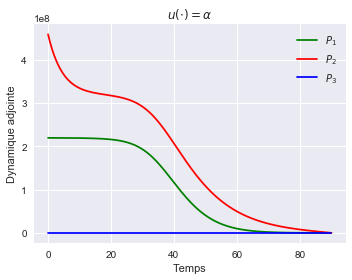

In [33]:
stepCount = 1000 # discretisation en temps
t = np.linspace(0,T,stepCount)

u = alpha*np.ones(stepCount)
# print(u)
Xvals = RungeKutta4(u, stepCount)
Pvals = RungeKutta4Adjoint(u, Xvals, stepCount)
# print(Pvals)

fig, ax = plt.subplots(1,1,figsize=(5,4))
plotAdjoint(t, Pvals, ax, "$u(\cdot) = \\alpha$", show=[0,1,2])

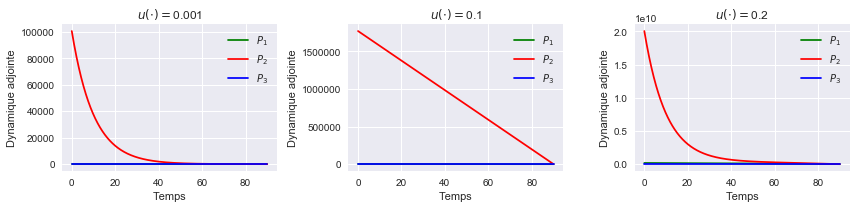

In [149]:
stepCount = 1000 # discretisation en temps
t = np.linspace(0,T,stepCount)

fig, ax = plt.subplots(1,3,figsize=(12,3))

epsilon = [1e-3, beta, 0.2]
for i in range(3):
    u = epsilon[i]*np.ones(stepCount)
    Xvals = RungeKutta4(u, stepCount)
    Pvals = RungeKutta4Adjoint(u, Xvals, stepCount)
    plotAdjoint(t, Pvals, ax[i], "$u(\cdot) =$"+str(epsilon[i]), show=[0,1,2])

### Implementons à présent la méthode de gradient. 

On commence par définir des constantes de normalisation pour chacun des termes du critère. Ensuite, nous définirons une fonction `RungeKutta4Augmented` permettant non seulement de résoudre le système d'état par une méthode de Runge-Kutta d'ordre 4, mais aussi d'évaluer le critère (normalisé). Pour finir, les fonctions `computeRho` et `GradientDescent` achèverons l'implémentation de la méthode de gradient. L'algorithme s'arrête si l'une des conditions suivantes est satisfaite :
- Erreur relative inférieure à une tolérance donnée ($tol=5e-6$). Cette forte tolérance est imposée pour palier le fait que l'algorithme s'arête aussi s'il ne trouve plus de direction descendante (voir troisième point).
- Nombre d'itérations supérieur au nombre maximal d'itérations ($nbIterMax = 1e4$).
- Une direction de décente n'a pas pu être trouvée. Dans ce cas, l'algorithme s'arrête prématurément et c'est à l'utilisateur de réduire le pas initial considéré, ou d'augmenter le nombre d'itérations dans la recherche d'un pas descendant.

In [6]:
## Coefficients de normalisation

# gNorm = 1
# fNorm = 1

gNorm = 4.6080000000000005
fNorm = 4471466652487757.0

In [151]:
## F augmentée pour calculer le critère
def FAugmented(t, X, u, tau):
    f1 = -u*X[0]*X[1]/N
    f2 = u*X[0]*X[1]/N - beta*X[1]
    f3 = beta*X[1]
    f4 = (tau*g(u)/gNorm) + ((1.0-tau)*f(X[1])/fNorm)
    return np.array([f1, f2, f3, f4])

def RungeKutta4Augmented(u, tau, stepCount):
    t = np.linspace(0,T,stepCount)
    h = t[1:] - t[:-1]          ## h_n = t_np1 - t_n
    
    Z0 = 0
    X = np.array([S0, I0, R0, Z0])
    Xvals = [list(X)]

    for n in range(stepCount-1):
        un = u[n]                                   ## u à cette étape

        k1 = FAugmented(t[n], X, un, tau)
        k2 = FAugmented(t[n]+h[n]/2.0, X+h[n]*k1/2.0, un, tau)    ## Euler explicite entre t_n et t_np1sur2
        k3 = FAugmented(t[n]+h[n]/2.0, X+h[n]*k2/2.0, un, tau)    ## Euler implicite entre t_n et t_np1sur2
        k4 = FAugmented(t[n]+h[n], X+h[n]*k3, un, tau)

        X += h[n] * (k1+2*k2+2*k3+k4) / 6.0
        Xvals.append(list(X))

    return np.vstack(Xvals)

In [152]:
def g(u):
    # return 0.5*(alpha**2 - u**2)
    alphaVec = alpha*np.ones_like(u)
    return 0.5*(alphaVec**2 - u**2)

def f(I):
    return 0.5*(I**2) 

## Approximation des composantes de L_tau par la méthode des rectangles
def Ltau(u, I, tau):        
    assert len(u)==len(I)
    gInt = (T/len(u))*np.sum(g(u))
    fInt = (T/len(I))*np.sum(f(I))

    # return (tau*gInt/gNorm) + ((1.0-tau)*fInt/fNorm)
    return tau*gInt/gNorm, (1.0-tau)*fInt/fNorm

## Calcule le gradient de L_tau
def gradLtau(u, S, I, P1, P2, tau):
    return -(tau*u/gNorm) + ((1.0-tau)/fNorm)*S*I*(P2-P1)/N

## Projection du u dans l'ensemble admissible
def projectu(u):
    alphaVec = alpha*np.ones_like(u)
    zeroVec = np.zeros_like(u)
    # print(u-rho*gradL)
    return np.minimum(alphaVec, np.maximum(u, zeroVec))

## Calcule le pas à considérer
def computeRho(u, I, tau, L, gradL, rho0, cptMax, stepCount, verbose=False):
    if verbose:
        print("  Searching for a decending step ...")

    rho = rho0
    # Lnow = L
    cpt = 0
    while True:

        uNext = projectu(u-rho*gradL)

        Xvals = RungeKutta4Augmented(uNext, tau, stepCount)
        S, I, R, Z = Xvals[:, 0], Xvals[:, 1], Xvals[:, 2], Xvals[:, 3]

        Lnow = Z[-1]
        delta = Lnow - L

        if cpt >= cptMax or delta < 0:
            break
        
        rho /= 1.3

        cpt += 1

    assert cpt < cptMax, "Decending step not found, try either \n - decreasing the initial \u03C1, or \n - increasing the max number of iterations"

    if verbose:
        print("    --- \u03C1 = %0.9f"%rho, "after", cpt, "iterations")

    return rho, uNext, Lnow


In [234]:
def GradientDescent(u0, tau, rho0, rhoIterMax, stepCount=100, verbose=False):
    u = u0
    tol = 5e-6  ## 5 pour 10000 de precision
    nbIterMax = 1e4

    print("\n------------------ Gradient descent ongoing ... ------------------------- \n")

    L = []
    iterCpt = 0
    while True:
        if verbose:
            print("############ "+"Iteration "+str(iterCpt)+" ############")
        
        ## Calcul de l'état X et évaluation du critère
        Xvals = RungeKutta4Augmented(u, tau, stepCount)
        S, I, R, Z = Xvals[:, 0], Xvals[:, 1], Xvals[:, 2], Xvals[:, 3]
        Lnow = Z[-1]
        L.append(Lnow)

        ## Calcul de l'adjoint P
        Pvals = RungeKutta4Adjoint(u, Xvals, stepCount)
        P1, P2, P3 = Pvals[:, 0], Pvals[:, 1], Pvals[:, 2]

        ## Calcul du gradient gradL
        gradL = gradLtau(u, S, I, P1, P2, tau)
        # print("gradL: ", gradL)

        ## Calcul du pas pour la descente
        try:
            # rho = computeRho(u, I, tau, Lnow, gradL, rho0, rhoIterMax, stepCount)
            rho, uNext, Lnext  = computeRho(u, I, tau, Lnow, gradL, rho0, rhoIterMax, stepCount, verbose)
        except AssertionError as errorRho:
            print("\n---------# Algorithm stopped before converging #-----------")
            print(errorRho)
            break

        ## Préparation pour l'itération suivante
        u = uNext
        iterCpt += 1
        # print("  Control u changes: ", not np.all(np.abs(u-uNext)<1e-3))

        ## Calcul de l'erreur
        error = abs(Lnext-Lnow)/abs(Lnow + np.finfo(np.float64).eps)
        if verbose:
            print("  Relative error = %0.6f"%error)
        if error < tol or iterCpt > nbIterMax:
            break

    ## Récupération des valeurs optimales
    Xvals = np.stack([S,I,R], axis=1)
    Pvals = np.stack([P1,P2,P3], axis=1)
    
    ## Evaluation approximative des diférents termes du crénau
    gInt, fInt = Ltau(u, I, tau)

    if iterCpt > 1:
        print("\nDONE:")
        print(" --Final objective:", Lnext)
        print(" --Competing objectives: g_int=", gInt, "   f_int=", fInt)
        print(" --Number of iterations:", iterCpt)
        print(" --Relative error: %0.8f"%error)
        # print(" --Optimal control", u)

    return Xvals, Pvals, u, np.array(L)

In [12]:
def plotu(t, u, ax, title):
    ax.plot(t, u, label="u", c='y')

    ax.set_xlabel("Temps")
    ax.set_ylabel("Taux de transmission")
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()

In [13]:
def plotL(L, ax, title):
    ax.plot(L, label="$L_{\\tau}$", c='purple')

    ax.set_xlabel("Itération")
    ax.set_ylabel("Critère")
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()

## Question 6

### Présentons des solution obtimale $u(\cdot)$ obtenue pour differentes valeurs de $\tau$. 

Nous commencerons par $\tau=0.5$, et nous lancerons le programme avec 3 initialisations différentes, toutes constantes ($u(\cdot)\approx 0$, $u(\cdot)=\alpha /2$, et $u(\cdot)=\alpha$). Les 3 cellules suivantes traduisent ces trois cas. 

> Du à l'affichage des informations importantes à chaque itérations, les graphiques peuvent se retrouver tous en bas des cellules, et pas immédiatement visibles. Il sera donc nécessite de faire défiler le contenu pour afficher les graphiques!


------------------ Gradient descent ongoing ... ------------------------- 

############ Iteration 0 ############
  Searching for a decending step ...
    --- ρ = 500.000000000 after 0 iterations
  Relative error = 0.000762
############ Iteration 1 ############
  Searching for a decending step ...
    --- ρ = 175.063898323 after 4 iterations
  Relative error = 0.234134
############ Iteration 2 ############
  Searching for a decending step ...
    --- ρ = 1.197492774 after 23 iterations
  Relative error = 0.002229
############ Iteration 3 ############
  Searching for a decending step ...
    --- ρ = 1.556740606 after 22 iterations
  Relative error = 0.019002
############ Iteration 4 ############
  Searching for a decending step ...
    --- ρ = 1.197492774 after 23 iterations
  Relative error = 0.007149
############ Iteration 5 ############
  Searching for a decending step ...
    --- ρ = 2.023762787 after 21 iterations
  Relative error = 0.000773
############ Iteration 6 ############
 

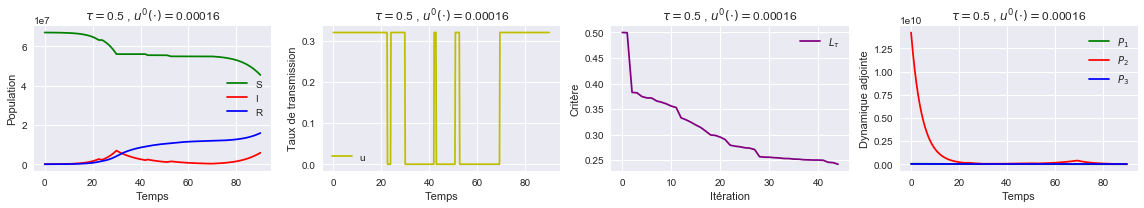

In [229]:
stepCount = 500
t = np.linspace(0,T,stepCount)

## Une intialisation à u=0 pose des problèmes de convergence
u0 = alpha*np.ones(shape=stepCount)/2000        ### alpha approx 0

tau = 0.50

rho0 = 5e+2
rhoIterMax = 2e2

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount, verbose=True)

fig, ax = plt.subplots(1,4,figsize=(16,3))
plotSIR(t, Xvals, ax[0], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])
plotu(t, u, ax[1], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotL(L, ax[2], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotAdjoint(t, Pvals, ax[3], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.23895520563415237
 --Competing objectives: g_int= 0.225    fint= 0.013629362678081179
 --Number of iterations: 40
 --Relative error: 0.00191620


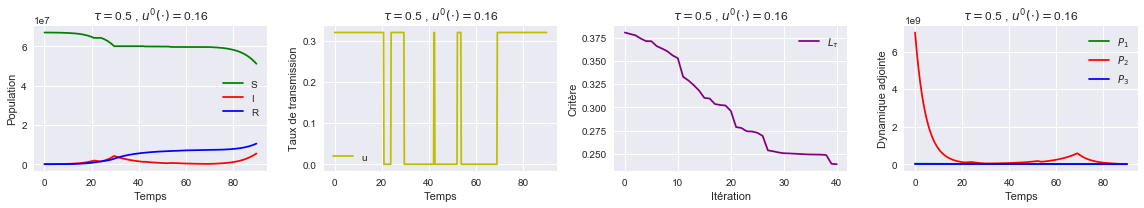

In [230]:
u0 = alpha*np.ones(shape=stepCount)/2
tau = 0.50

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount, verbose=False)

fig, ax = plt.subplots(1,4,figsize=(16,3))
plotSIR(t, Xvals, ax[0], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])
plotu(t, u, ax[1], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotL(L, ax[2], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotAdjoint(t, Pvals, ax[3], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.2751849403753951
 --Competing objectives: g_int= 0.257    fint= 0.01764250758607702
 --Number of iterations: 20
 --Relative error: 0.03345198


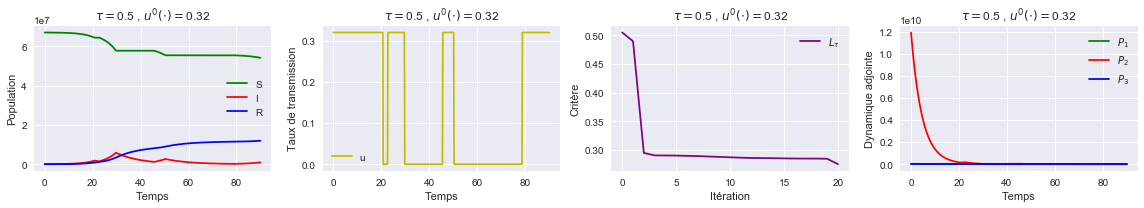

In [231]:
u0 = alpha*np.ones(shape=stepCount)/1
tau = 0.50

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount, verbose=False)

fig, ax = plt.subplots(1,4,figsize=(16,3))
plotSIR(t, Xvals, ax[0], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])
plotu(t, u, ax[1], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotL(L, ax[2], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotAdjoint(t, Pvals, ax[3], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])

Pour $\tau = 0.5$, la meilleure minimisation est obtenue pour une initialisation $u(\cdot)=\frac{\alpha}{2000} \approx 0$. Le critère vaut alors $L_{\tau}(u^*) = 0.2418$.


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.028032192380481154
 --Competing objectives: g_int= 0.027000000000000003    f_int= 0.0009878117753646164
 --Number of iterations: 63
 --Relative error: 0.00075617


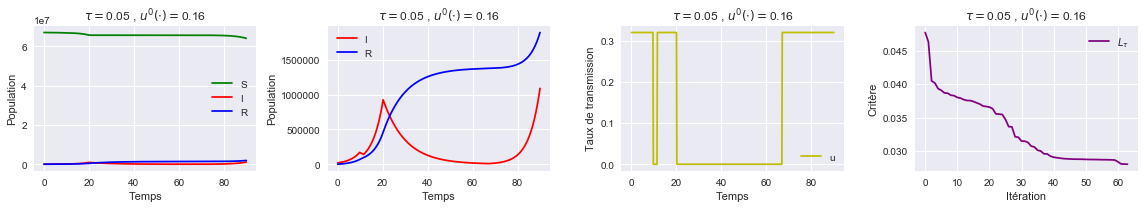

In [236]:
u0 = alpha*np.ones(shape=stepCount)/2
tau = 0.05
rho0 = 5e+2
rhoIterMax = 2e2

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount, verbose=False)

fig, ax = plt.subplots(1,4,figsize=(16,3))
plotSIR(t, Xvals, ax[0], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])
plotSIR(t, Xvals, ax[1], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1])
plotu(t, u, ax[2], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotL(L, ax[3], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))

Pour $\tau = 0.05$ proche de $0$, on observe bien une tendance à minimiser le nombre d'infectés au détriment du coût du confinement. Et la valeur du critère obtenu est considérablement faible $L_{\tau}(u^*) = 0.028$ comparé au cas ci-haut où les deux termes du critère étaient équitablement pris en compte ($\tau=0.5$), qui donnait $L_{\tau}(u^*) = 0.2418
$.


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.24448994042848016
 --Competing objectives: g_int= 0.009    fint= 0.235004068314908
 --Number of iterations: 3
 --Relative error: 0.02907790


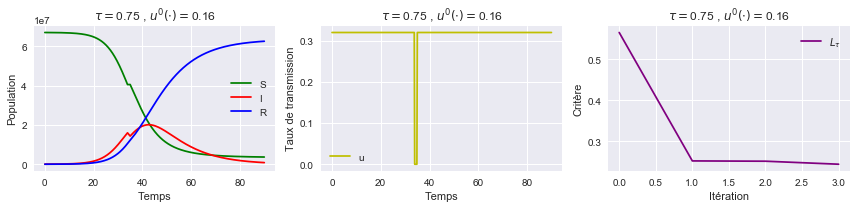

In [233]:
u0 = alpha*np.ones(shape=stepCount)/2
tau = 0.75
rho0 = 5e+2
rhoIterMax = 2e2

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount, verbose=False)

fig, ax = plt.subplots(1,3,figsize=(12,3))
plotSIR(t, Xvals, ax[0], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]), show=[2,1,0])
plotu(t, u, ax[1], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))
plotL(L, ax[2], "$\\tau = $"+str(tau)+" , $u^0(\cdot)=$"+str(u0[0]))

Ce cas confirme bien que pour $\tau = 0.75$, le système a tendence à mettre la priorité sur la minimisation du cout du confinement, en prenant $u$ proche de $\alpha$. 

## Question 7

### (a) Diagramme de Pareto

Pour des raisons d'efficacité, les différentes intégrales $\int_0^T g(u^*_\tau(t))$ et $\int_0^T f(I^*_\tau(t))$ seront estimées par la méthode des rectangles, en vue de l'affichage. Cependant, les différentes résolutions du problème de minimisation utiliserons bien sûr des calculs exact de ces intégrales pour l'évaluation du critère $L_{\tau}$ (durant l'algorithme de Runge-Kutta).

In [237]:
u0 = alpha*np.ones(shape=stepCount)/2
rho0 = 5e+2
rhoIterMax = 2e2

tauList = np.linspace(0, 1, 20)
PeretoData = []

for tau in tauList:
    Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount)
    
    I = Xvals[:,1]
    gInt = (T/len(u))*np.sum(g(u)) / gNorm
    fInt = (T/len(I))*np.sum(f(I)) / fNorm

    PeretoData.append([gInt, fInt])

PeretoData = np.array(PeretoData)


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.029607528210573643
 --Competing objectives: g_int= 0.028526315789473688    f_int= 0.0010323020942609644
 --Number of iterations: 62
 --Relative error: 0.00036958

------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.05686463441321775
 --Com

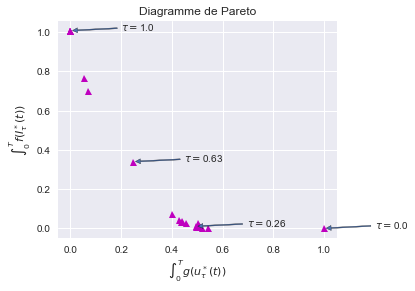

In [261]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(PeretoData[:,0], PeretoData[:,1], "^", color="m")

lenTau = len(tauList)
for i in [0, lenTau//4, 3*lenTau//5, lenTau-1]:
    x, y =  PeretoData[i,0], PeretoData[i,1]
    ax.annotate("$\\tau=$"+str(round(tauList[i],2)), xy=(x,y), xytext=(x+0.2, y), arrowprops=dict(arrowstyle="simple,tail_width=0.1"))

ax.set_xlabel("$\int_0^T g(u^*_\\tau(t))$")
ax.set_ylabel("$\int_0^T f(I^*_\\tau(t))$")
ax.set_title("Diagramme de Pareto")
# plt.savefig("DiagrammePeretorNewNew2.png")

Vu qu'on a deux termes à minimiser qui sont contradictoires (en concurrence), ce diagramme nous donne une idée sur l'impact d'un choix de minimisation en priorité sur l'autre. Il nous indique de combien (en termes de coût de confinement) on souffrira si on décide de se focaliser sur l'extinction de l'épidémie, et inversement. On constate par exemple que pour $\tau=0.63$, on a un bon compromis entre limitation du confinement et limitation du nombre d'infectés.

### b) En utilisant Gekko

In [25]:
m = GEKKO() # initialize gekko
nt = 1001    ## 
m.time = np.linspace(0,90,nt)

# Variables
S = m.Var(value=S0)
I = m.Var(value=I0)
R = m.Var(value=R0)
Z = m.Var(value=0)

u = m.MV(value=alpha/2,lb=0,ub=alpha)
u.STATUS=1

p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p)

# Equations
tau = 0.05 # 0.63
m.Equation(S.dt()==-u*S*I/N)
m.Equation(I.dt()==(u*S*I/N)-beta*I)
m.Equation(R.dt()==beta*I)
m.Equation(Z.dt()==(tau*(alpha**2 - u**2)*0.5/gNorm) + ((1.0-tau)*(I**2)*0.5/fNorm))

m.Obj(Z*final) # Objective function
m.options.IMODE = 6         # 3, 6 or 9 for optimal control minimisation mode
# m.options.SOLVER = 1

m.options.RTOL = 5e-6       ## Relative tol for the equations
m.options.OTOL = 5e-6       ## Relative tol for the objective fucntion
m.options.MAX_ITER = 500

m.solve(disp=False) # solve

In [23]:
# m.open_folder()

RESULTS USING GEKKO
Objective value: 0.03822891316


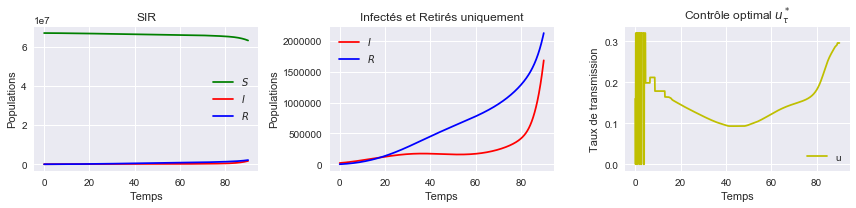

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(m.time,S.value,'g-',label=r'$S$')
ax1.plot(m.time,I.value,'r-',label=r'$I$')
ax1.plot(m.time,R.value,'b-',label=r'$R$')
ax1.legend(loc='best')
ax1.set_xlabel('Temps')
ax1.set_ylabel('Populations')
ax1.set_title("SIR")

ax2.plot(m.time,I.value,'r-',label=r'$I$')
ax2.plot(m.time,R.value,'b-',label=r'$R$')
ax2.legend(loc='best')
ax2.set_xlabel('Temps')
ax2.set_ylabel('Populations')
ax2.set_title("Infectés et Retirés uniquement")

# ax3.plot(m.time,u.value,'y-',label=r'$u$')
# ax3.legend(loc='best')
# ax3.set_xlabel('Temps')
# ax3.set_title('Contrôle optimal $u^*_{\\tau}$')

plotu(m.time, u.value, ax3, "Contrôle optimal $u^*_{\\tau}$")
plotL(Z.value, ax4, "Diminution du critère")

print("RESULTS USING GEKKO")
print("Objective value:", Z.value[-1])
plt.tight_layout();
plt.show();


------------------ Gradient descent ongoing ... ------------------------- 


---------# Algorithm stopped before converging #-----------
Decending step not found, try either 
 - decreasing the initial ρ, or 
 - increasing the max number of iterations

DONE:
 --Final objective: 0.23895520563415237
 --Competing objectives: g_int= 0.225    f_int= 0.013629362678081179
 --Number of iterations: 40
 --Relative error: 0.00191620


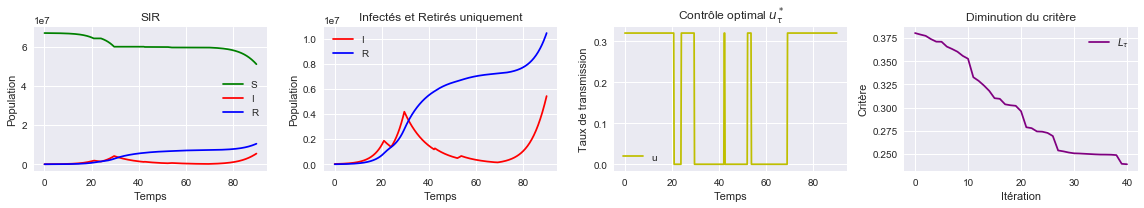

In [314]:
## Rappel des résultats obtenus par la méthode de gradient 
stepCount = 500
t = np.linspace(0,T,stepCount)
u0 = alpha*np.ones(shape=stepCount)/2 
tau = 0.50
rho0 = 5e+2
rhoIterMax = 2e2

Xvals, Pvals, u, L = GradientDescent(u0, tau, rho0, rhoIterMax, stepCount)

fig, ax = plt.subplots(1,4,figsize=(16,3))
plotSIR(t, Xvals, ax[0], "SIR", show=[2,1,0])
plotSIR(t, Xvals, ax[1], "Infectés et Retirés uniquement", show=[2,1])
plotu(t, u, ax[2], "Contrôle optimal $u^*_{\\tau}$")
plotL(L, ax[3], "Diminution du critère")

En général les résultats obtenus par Gekko ne sont pas identiques à ceux calculés par l'algorithme de descente de gradient que nous avons implémenté plus-haut (et dont un résultat est rappelé dans la cellule du dessus). Cependant, les stratégies appliquées sont généralement les mêmes. Pour $\tau=0.05$ par exemple (les figures ci-haut), la stratégie optimale consiste globalement à éviter le confinement durant les 30 premiers jours, ensuite de confiner jusqu'au 70-ème jours, avant de déconfiner à nouveau. 

On constate aussi que l'algorithme de Gekko fournit très souvent des critères optimaux très inférieurs aux nôtres, muni des mêmes termes de normalisation. 

### c) Enrichissement de la modélisation proposée

Pour enrichir la modélisation proposée, on pourrait déjà prendre en compte les populations retirées. Les personnes infectées puis guéries pourraient par exemple recontracter le virus pour retourner dans la catégorie des infectés ; autrement dit, il s'agit de supprimer l'hypothèse que le virus procure une immunité après qu'on l'ait contracté. L'enrichissement le plus intéressant pour cette étude (contexte de COVID-19) serait donc l'ajout du taux de mortalité $\mu$ du virus, afin de bien différencier les retirés (immunisés ou en quarantaine) des décédés. Le modèle SIRD est donc:

\begin{align*}
S'(t) &= -u(t) \frac{S(t)I(t)}{N(t)} \\
I'(t) &= u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) -\mu I \\
R'(t) &= \beta I(t) \\
D'(t) &= \mu I(t) \\
(S(0),I(0),R(0),D(0)) &= (S_0, R_0, I_0, D_0)
\end{align*}

Le calcul du gradient devrait être similaire a celui du problème que nous avons résolu dans ce notebook, et l'implémentation de la méthode de gradient aussi. Pour un virus comme le COVID qui ne procure pas d'immunité, l'inclusion du taux de mortalité dans l'étude est malheureusement crucial.

Pour un contrôle constant, résolvons le système SIRD par une méthode de Runge-Kutta d'ordre 4.

In [59]:
## Paremetres pour le modèle SIRD
S0, I0, R0, D0 = 6.7e7-2e4, 2e4, 0, 0
N = 6.7e7
T = 90
alpha = 0.32
beta = 0.04
mu = 0.06

In [60]:
def F(t, X, u):
    f1 = -u*X[0]*X[1]/N
    f2 = u*X[0]*X[1]/N - beta*X[1] - mu*X[1]
    f3 = beta*X[1]
    f4 = mu*X[1]
    return np.array([f1, f2, f3, f4])

def RungeKutta4(u, stepCount):
    t = np.linspace(0,T,stepCount)
    h = t[1:] - t[:-1]          ## h_n = t_np1 - t_n
    
    X = np.array([S0, I0, R0, D0])
    Xvals = [list(X)]

    for n in range(stepCount-1):
        un = u[n]                                   ## u à cette étape

        k1 = F(t[n], X, un)
        k2 = F(t[n]+h[n]/2.0, X+h[n]*k1/2.0, un)    ## Euler explicite entre t_n et t_np1sur2
        k3 = F(t[n]+h[n]/2.0, X+h[n]*k2/2.0, un)    ## Euler implicite entre t_n et t_np1sur2
        k4 = F(t[n]+h[n], X+h[n]*k3, un)

        X += h[n] * (k1+2*k2+2*k3+k4) / 6.0
        Xvals.append(list(X))

    return np.vstack(Xvals)

In [67]:
## Une fonctino pour afficher l'état du système
def plotSIRD(t, Xvals, ax, title, show=[0,1,2,3]):

    if 0 in show or show is None:
        ax.plot(t, Xvals[:,0], label="S", c='g')
    if 1 in show or show is None:
        ax.plot(t, Xvals[:,1], label="I", c='r')
    if 2 in show or show is None:
        ax.plot(t, Xvals[:,2], label="R", c='b')
    if 3 in show or show is None:
        ax.plot(t, Xvals[:,3], '.-', label="D", c='orange')

    ax.set_xlabel("Temps")
    ax.set_ylabel("Population")
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()

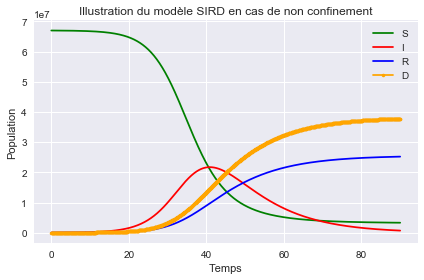

In [68]:
stepCount = 1000 # discretisation en temps
t = np.linspace(0,T,stepCount)

u = alpha*np.ones(stepCount)
Xvals = RungeKutta4(u, stepCount)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plotSIRD(t, Xvals, ax, "Illustration du modèle SIRD en cas de non confinement")

Nous avons simplement scindé le précédent groupe des retirés en "retirés (R)"(immunisés ou mis en quarantaine) et "décédés (D)" à raison de 40 % et 60 % respectivement ($\beta = 0.04$ et $\mu=0.06$). Le contrôle utilisé est celui correspondant à une absence totale de confinement ($u(\cdot)=\alpha$). Le graphique ci-haut permet effectivement de constater que la majorités des personnes retirés le sont à cause d'un décès. Une étude plus approfondie de ce modèle (tout aussi prometteur que celui que nous avons profondément étudié dans ce notebook) pourra être envisagée ultérieurement.